In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import math

In [ ]:
# Total de unidades de produção para autoconsumo
drive.mount('/content/drive')
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/tese/8-unidades-de-producao-para-autoconsumo-novo.parquet')
shapefile = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/tese/cont-aad-caop2017/Cont_AAD_CAOP2017.shp")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/tese/8-unidades-de-producao-para-autoconsumo.parquet')
df1 = df1[df1['trimestre'].isin(['2022T2', '2022T3'])]
df1 = df1.rename(columns={'freguesias': 'freguesia', 'coddistritoconcelho': 'codconcelho', 'coddistritoconcelhofreguesia': 'codfreguesia', 'potencia_total_instalada_upac_kw':  'potencia_instalada_upac_kw'})
# df1

In [ ]:
combined_df = pd.concat([df, df1], ignore_index=True)
df = combined_df
# combined_df

In [ ]:
# df['escalao_de_potencia_instalada'] = df['escalao_de_potencia_instalada'].replace(['> 1000', '>1000'], '>1000')
replacement_map = {
    '> 1000': '>1000',
    ']0,4]': ']0, 4]',
    ']4,20.7]': ']4, 20.7]',
    ']20.7,30]': ']20.7, 30]',
    ']30,1000]': ']30, 1000]'
}
df['escalao_de_potencia_instalada'] = df['escalao_de_potencia_instalada'].replace(replacement_map)
df = df[df['escalao_de_potencia_instalada'] != 'ND']
df['escalao_de_potencia_instalada'].value_counts()
desired_order = [']0, 4]',']4, 20.7]', ']20.7, 30]',']30, 1000]', '>1000']
df = df.merge(shapefile, left_on='codfreguesia', right_on='Dicofre', how='left')
df = df.drop(['Dicofre', 'Freguesia', 'Concelho', 'Distrito', 'TAA', 'AREA_EA_Ha', 'AREA_T_Ha', 'Des_Simpli'], axis=1, errors='ignore')

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=df["geometry"])

In [ ]:
# gdf.head()
# Group by 'coddistritoconcelho' and aggregate the corresponding fields
# correspondence_table = gdf.groupby('coddistritoconcelhofreguesia').agg({
#     'distrito': 'first',
#     'concelho': 'first',
#     'freguesias': 'first',
#     'numero_de_instalacoes': 'sum'
# }).reset_index()

correspondence_table = gdf.groupby('codconcelho').agg({
    'distrito': 'first',
    'concelho': 'first'
}).reset_index()

correspondence_table

,codconcelho,distrito,concelho
0,0101,Aveiro,Águeda
1,0102,Aveiro,Albergaria-a-Velha
2,0103,Aveiro,Anadia
3,0104,Aveiro,Arouca
4,0105,Aveiro,Aveiro
...,...,...,...
273,1820,Viseu,Tarouca
274,1821,Viseu,Tondela
275,1822,Viseu,Vila Nova de Paiva
276,1823,Viseu,Viseu


In [ ]:
target_concelho = 'Cascais'

concelho_code = correspondence_table[correspondence_table['concelho'] == target_concelho]['codconcelho']

concelho_code

,codconcelho
151,1105


In [ ]:
dissolved_list = []

# Loop over each trimestre and dissolve by coddistrito
for trimestre, group in gdf.groupby('trimestre'):
    dissolved = group.dissolve(by='coddistrito', aggfunc={'numero_de_instalacoes': 'sum'})
    dissolved['trimestre'] = trimestre
    dissolved_list.append(dissolved)

# Combine all dissolved pieces
gdf_distrito_trimestre = gpd.GeoDataFrame(pd.concat(dissolved_list).reset_index())
# gdf_distrito_trimestre

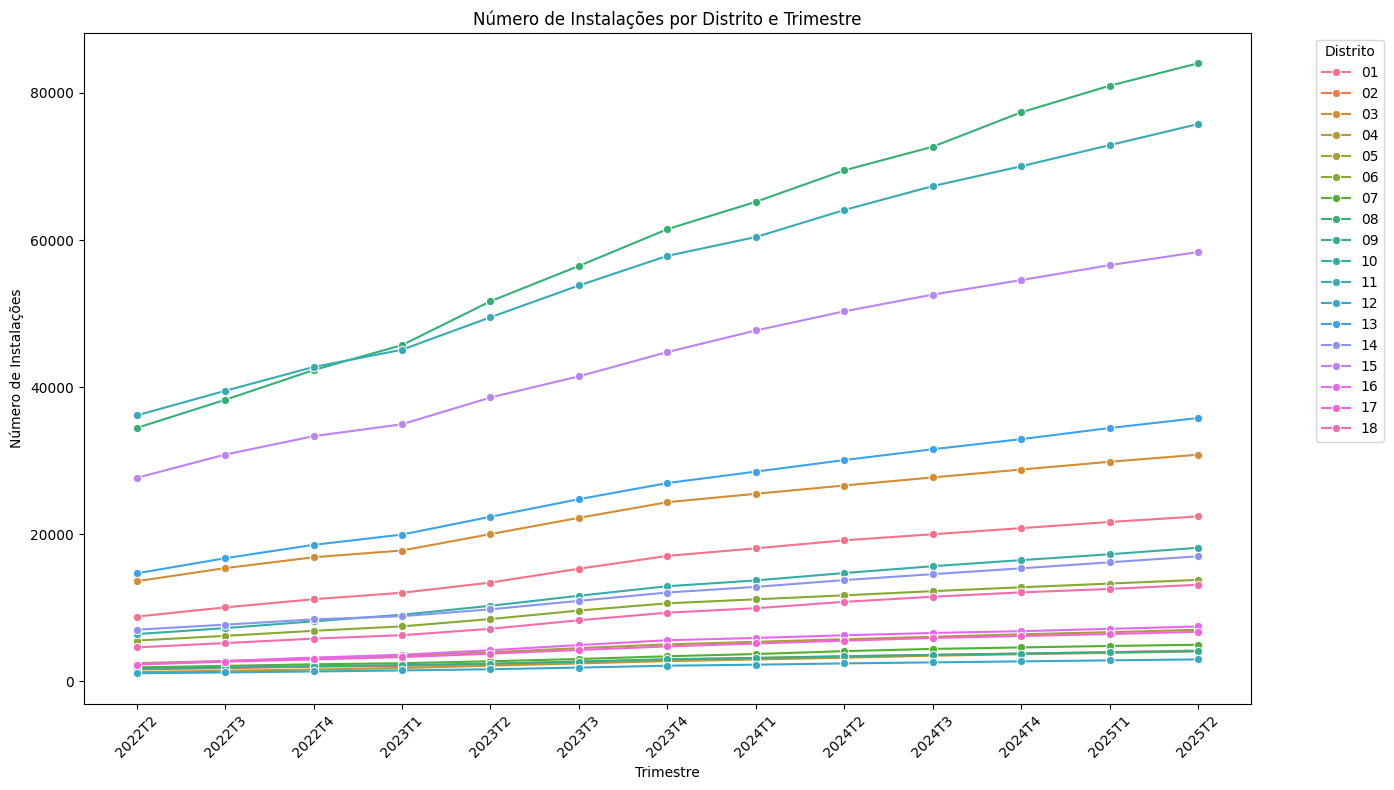

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=gdf_distrito_trimestre, x='trimestre', y='numero_de_instalacoes', hue='coddistrito', marker='o')
plt.xticks(rotation=45)
plt.title('Número de Instalações por Distrito e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Número de Instalações')
plt.legend(title='Distrito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

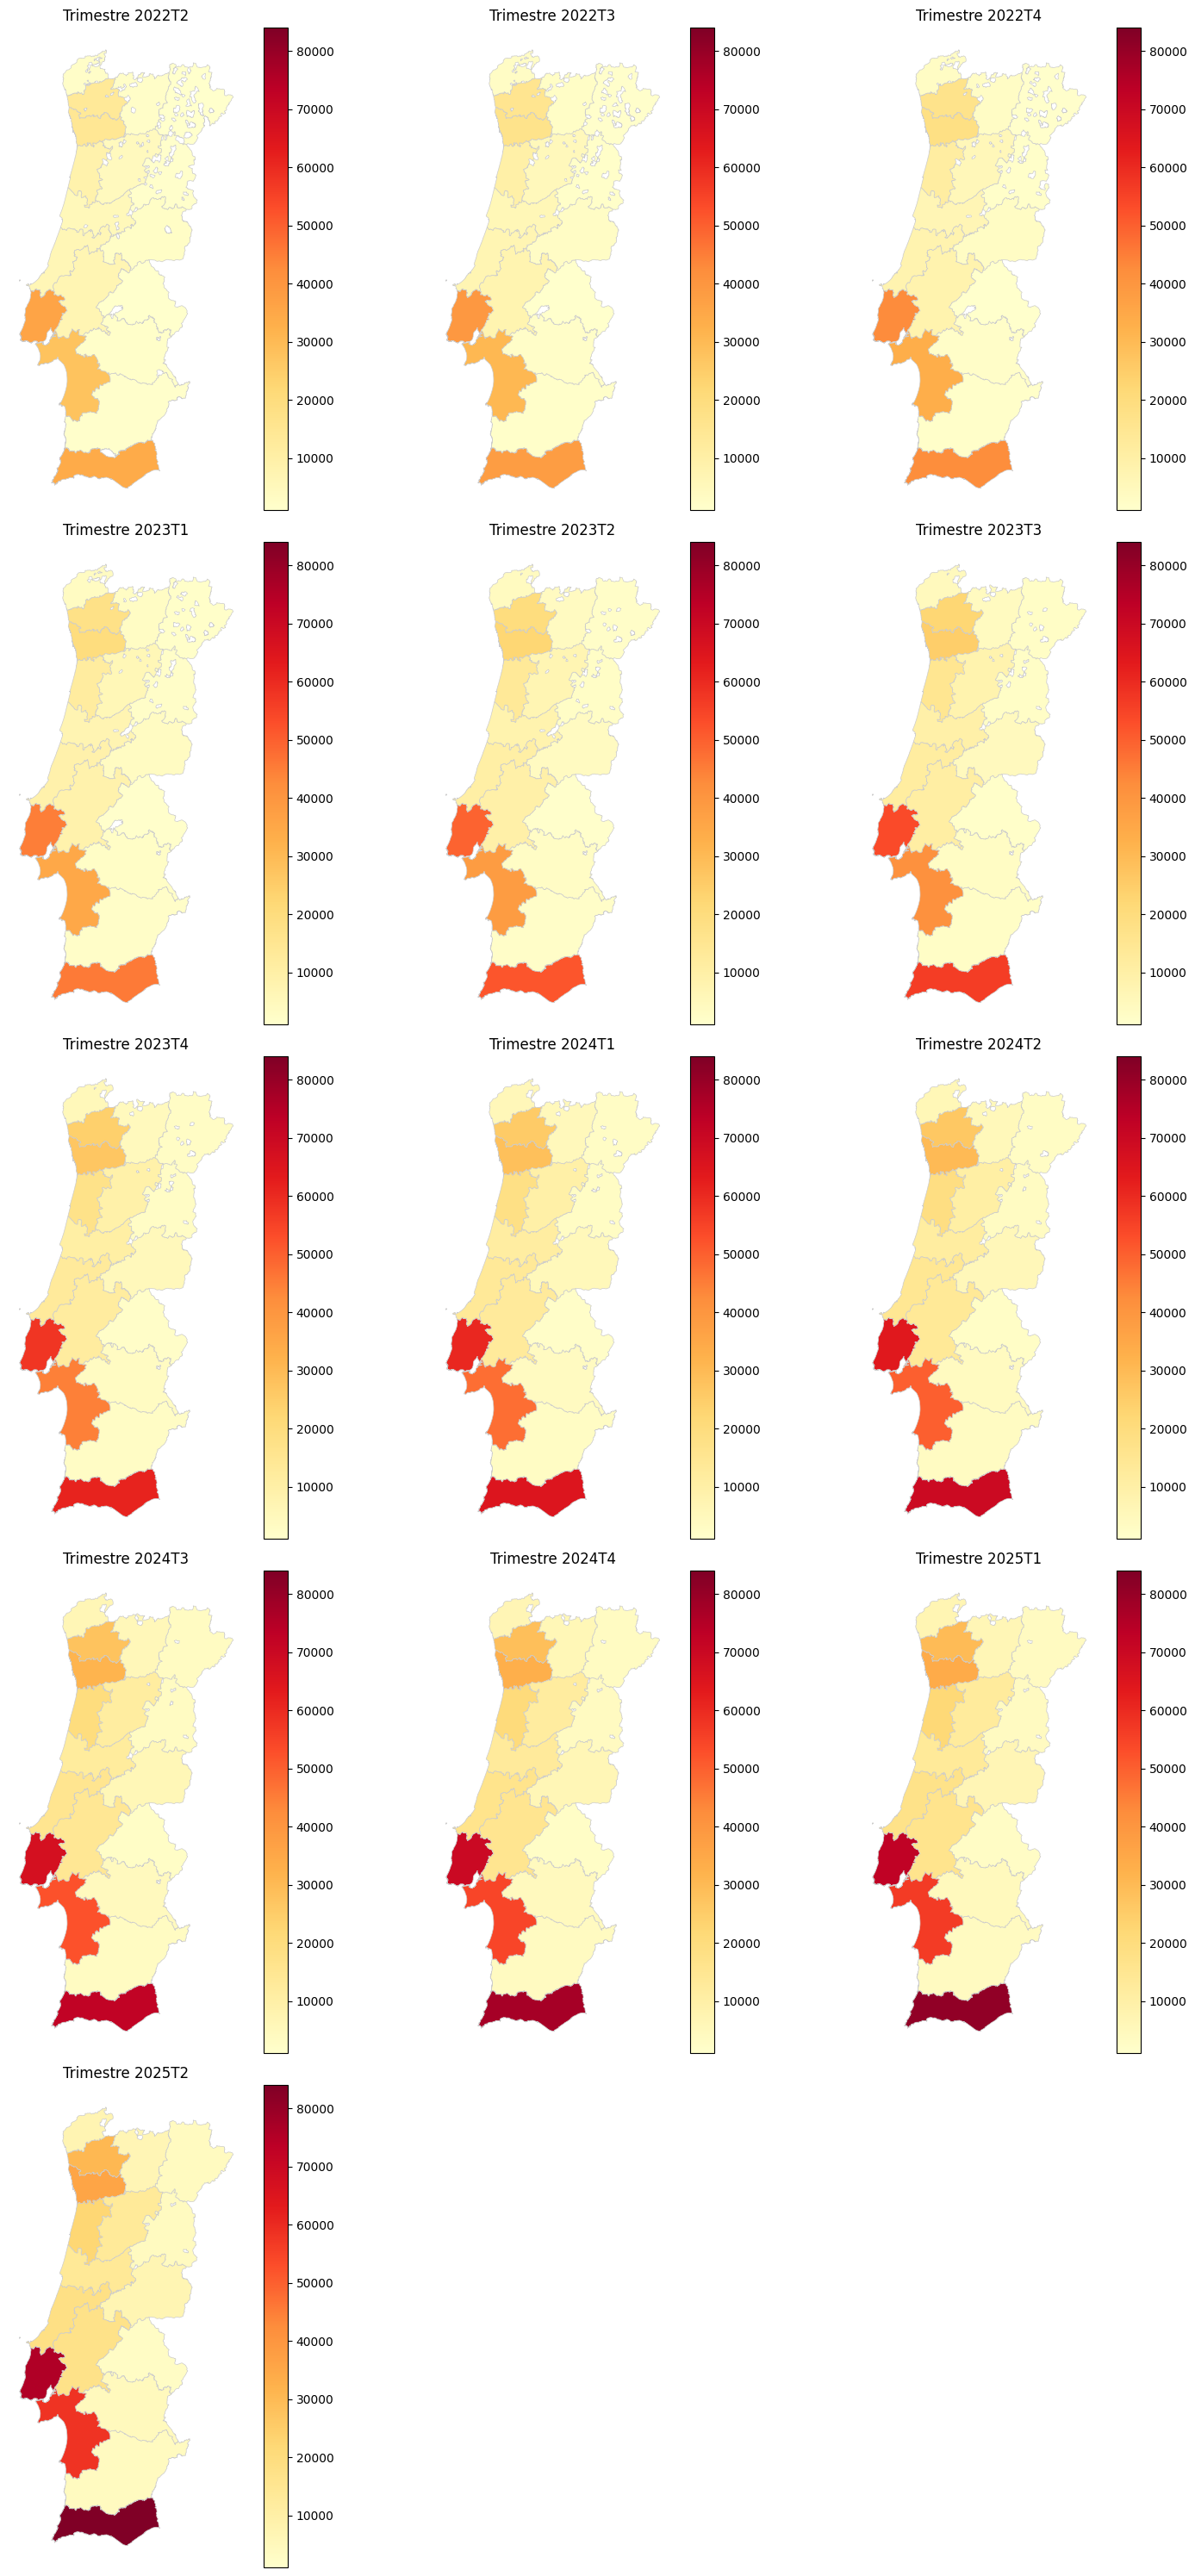

In [ ]:
trimestres = sorted(gdf_distrito_trimestre['trimestre'].unique())

vmin = gdf_distrito_trimestre['numero_de_instalacoes'].min()
vmax = gdf_distrito_trimestre['numero_de_instalacoes'].max()

# Set number of columns per row
cols = 3
rows = math.ceil(len(trimestres) / cols)

# Create figure and axes grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
axes = axes.flatten()

for i, trimestre in enumerate(trimestres):
    ax = axes[i]
    subset = gdf_distrito_trimestre[gdf_distrito_trimestre['trimestre'] == trimestre]

    subset.plot(column='numero_de_instalacoes',
                cmap='YlOrRd',
                linewidth=0.5,
                edgecolor='0.8',
                legend=True,
                ax=ax,
                vmin=vmin,
                vmax=vmax)
    ax.set_title(f"Quarter {trimestre}", fontsize=12)
    ax.axis('off')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

trimestre
2022T2    18
2025T2    18
Name: count, dtype: int64


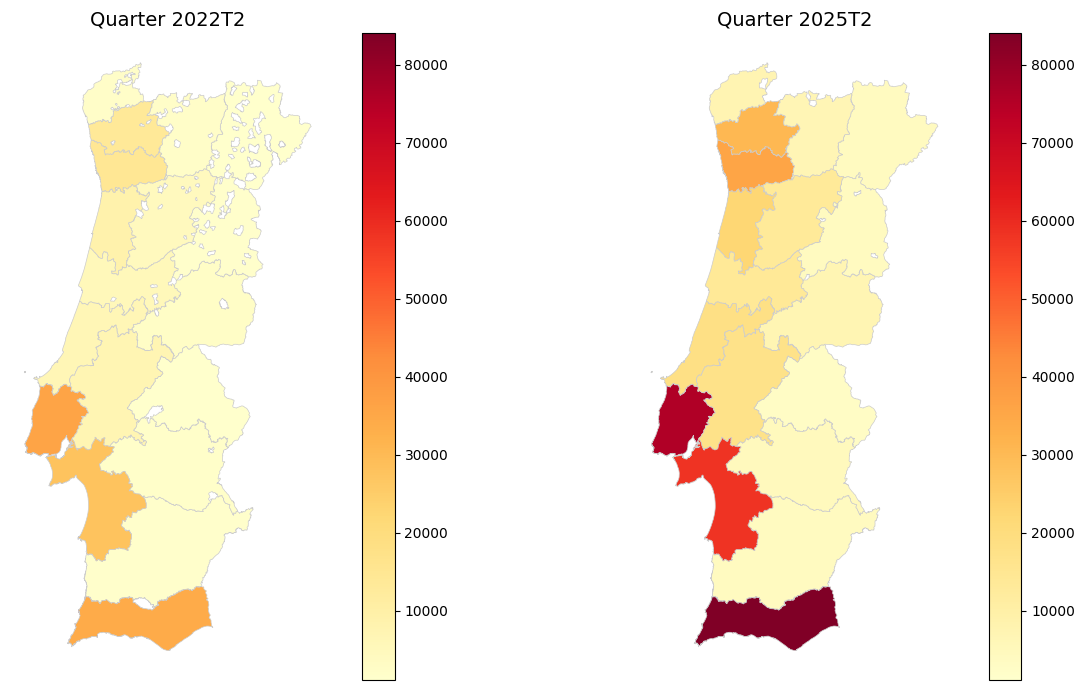

In [77]:
# Define the target trimestres
target_trimestres = ['2022T2', '2025T2']

# Filter the GeoDataFrame directly
subset = gdf_distrito_trimestre[gdf_distrito_trimestre['trimestre'].isin(target_trimestres)]

# Double-check: does subset contain data?
print(subset['trimestre'].value_counts())  # Optional debug line

# Compute shared vmin/vmax
vmin = subset['numero_de_instalacoes'].min()
vmax = subset['numero_de_instalacoes'].max()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i, trimestre in enumerate(target_trimestres):
    ax = axes[i]
    data = subset[subset['trimestre'] == trimestre]

    data.plot(column='numero_de_instalacoes',
              cmap='YlOrRd',
              linewidth=0.5,
              edgecolor='0.8',
              legend=True,
              ax=ax,
              vmin=vmin,
              vmax=vmax)

    ax.set_title(f"Quarter {trimestre}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Analise por distrito

In [ ]:
dissolved_concelho_list = []

for trimestre, group in gdf.groupby('trimestre'):
    dissolved = group.dissolve(by='codconcelho', aggfunc={'numero_de_instalacoes': 'sum'})
    dissolved['trimestre'] = trimestre
    dissolved_concelho_list.append(dissolved)

# Combine all into one GeoDataFrame
gdf_concelho_trimestre = gpd.GeoDataFrame(pd.concat(dissolved_concelho_list).reset_index())


In [ ]:
def plot_concelhos_by_distrito_and_trimestre(gdf_concelho_trimestre, distrito_code, trimestre, cmap='YlOrRd'):
    """
    Plots the number of installations for all concelhos in a given distrito and trimestre.

    Parameters:
    - gdf_concelho_trimestre: GeoDataFrame with dissolved concelhos and 'trimestre'
    - distrito_code: str or int (e.g., '11' for Lisboa)
    - trimestre: str (e.g., '2024T4')
    - cmap: str (colormap for plotting, default='YlOrRd')
    """
    distrito_code = str(distrito_code).zfill(2)  # Ensure it's two digits
    gdf_concelho_trimestre['distrito'] = gdf_concelho_trimestre['codconcelho'].str[:2]

    concelhos = gdf_concelho_trimestre[gdf_concelho_trimestre['distrito'] == distrito_code]
    subset = concelhos[concelhos['trimestre'] == trimestre]

    if subset.empty:
        print(f"No data found for distrito {distrito_code} in {trimestre}.")
        return

    fig, ax = plt.subplots(figsize=(10, 8))
    subset.plot(column='numero_de_instalacoes',
                cmap=cmap,
                linewidth=0.5,
                edgecolor='0.8',
                legend=True,
                ax=ax)
    ax.set_title(f'Concelhos do Distrito {distrito_code} – {trimestre}', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# gdf_concelho_trimestre['distrito'] = gdf_concelho_trimestre['coddistritoconcelho'].str[:2]

# concelhos = gdf_concelho_trimestre[gdf_concelho_trimestre['distrito'] == '11']
# trimestre_to_plot = '2024T4'
# subset = concelhos[concelhos['trimestre'] == trimestre_to_plot]

# fig, ax = plt.subplots(figsize=(10, 8))
# subset.plot(column='numero_de_instalacoes',
#             cmap='YlOrRd',
#             linewidth=0.5,
#             edgecolor='0.8',
#             legend=True,
#             ax=ax)
# ax.set_title(f'Concelhos do Distrito de Lisboa – {trimestre_to_plot}', fontsize=14)
# ax.axis('off')
# plt.tight_layout()
# plt.show()
plot_concelhos_by_distrito_and_trimestre(gdf_concelho_trimestre, '11', '2024T4')

KeyError: 'coddistritoconcelho'

# Analyse by Concelho

In [ ]:
coddistritoconcelho_code = '1105'
gdf_coddistritoconcelho = gdf[gdf['codconcelho'] == coddistritoconcelho_code]

In [ ]:
trimestre_to_plot = '2024T4'
subset_trimestre = gdf_coddistritoconcelho[gdf_coddistritoconcelho['trimestre'] == trimestre_to_plot]

# Plot installations for 'freguesias' within the selected 'coddistritoconcelho' and 'trimestre'
fig, ax = plt.subplots(figsize=(10, 8))
subset_trimestre.plot(column='numero_de_instalacoes',
                      cmap='YlOrRd',
                      linewidth=0.5,
                      edgecolor='0.8',
                      legend=True,
                      ax=ax)

ax.set_title(f'Instalações no Concelho de {coddistritoconcelho_code} – {trimestre_to_plot}', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()